Sales forecasting Model using XGBoost

In [2]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 2: Load and prepare the dataset
# Adjust the file path as needed
file_path = 'C:/Users/bhavy/Downloads/online_retail_II.xlsx'

# Read the data from the Excel file and merge sheets if needed
df_2009 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
df_2010 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
df = pd.concat([df_2009, df_2010])

# Convert InvoiceDate to datetime and sort by date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values(by='InvoiceDate')

# Step 3: Data Cleaning
# Remove canceled orders
df = df[~df['Invoice'].str.startswith('C', na=False)]

# Remove rows with missing Customer IDs and negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0) & df['Customer ID'].notnull()]

# Create a 'Sales' column
df['Sales'] = df['Quantity'] * df['Price']

# Step 4: Feature Engineering
# Create time-based features
df['day_of_week'] = df['InvoiceDate'].dt.day_name()
df['day_of_month'] = df['InvoiceDate'].dt.day
df['week_of_year'] = df['InvoiceDate'].dt.isocalendar().week
df['month'] = df['InvoiceDate'].dt.month
df['year'] = df['InvoiceDate'].dt.year
df['quarter'] = df['InvoiceDate'].dt.quarter

# Add holiday indicator (0 = Not a holiday, 1 = Holiday)
# Manually define holiday dates as a list and create an indicator column
holidays = pd.to_datetime([
    '2009-12-25', '2010-12-25', '2011-01-01', # Add other relevant holidays
])
df['is_holiday'] = df['InvoiceDate'].isin(holidays).astype(int)

# Add a feature for holiday season (1 = Holiday season, 0 = Non-holiday season)
df['holiday_season'] = np.where(df['month'].isin([11, 12, 1]), 1, 0)

# Add holiday season type feature (e.g., 'Christmas', 'New Year')
df['holiday_season_type'] = np.where(df['InvoiceDate'].isin(['2009-12-25', '2010-12-25']), 'Christmas', 
                                     np.where(df['InvoiceDate'].isin(['2011-01-01']), 'New Year', 'None'))

# Create the 'season' feature based on the month
df['season'] = np.where(df['month'].isin([12, 1, 2]), 'Winter', 
                        np.where(df['month'].isin([3, 4, 5]), 'Spring', 
                                 np.where(df['month'].isin([6, 7, 8]), 'Summer', 'Fall')))

# Step 5: Encode categorical features
# Initialize the label_encoders dictionary
label_encoders = {}

# Encode 'day_of_week'
label_encoders['day_of_week'] = LabelEncoder()
df['day_of_week_encoded'] = label_encoders['day_of_week'].fit_transform(df['day_of_week'])

# Encode 'season'
label_encoders['season'] = LabelEncoder()
df['season_encoded'] = label_encoders['season'].fit_transform(df['season'])

# Encode 'holiday_season_type'
label_encoders['holiday_season_type'] = LabelEncoder()
df['holiday_season_type_encoded'] = label_encoders['holiday_season_type'].fit_transform(df['holiday_season_type'])

# Verify that the required columns are present
print("Columns after encoding:", df.columns)

# Step 6: Prepare data for XGBoost
features = [
    'Quantity', 'Price', 'day_of_week_encoded', 'day_of_month', 'week_of_year',
    'month', 'is_holiday', 'season_encoded', 'quarter', 'holiday_season', 
    'holiday_season_type_encoded'
]

X = df[features]
y = df['Sales']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 7: Train XGBoost Model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Step 8: Forecast and Evaluate
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Define a function to calculate sMAPE
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

# Calculate sMAPE between actual and forecasted values
smap_value = smape(y_test, y_pred)

# Calculate Forecast Error and Tracking Signal
errors = y_test - y_pred
cfe = errors.sum()  # Cumulative Forecast Error
mad = errors.abs().mean()  # Mean Absolute Deviation
tracking_signal = cfe / mad

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"sMAPE: {smap_value:.2f}%")
print(f"Tracking Signal: {tracking_signal:.2f}")

C:\Users\bhavy\AppData\Local\Temp\ipykernel_20424\3048610869.py:53: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['holiday_season_type'] = np.where(df['InvoiceDate'].isin(['2009-12-25', '2010-12-25']), 'Christmas',
C:\Users\bhavy\AppData\Local\Temp\ipykernel_20424\3048610869.py:54: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  np.where(df['InvoiceDate'].isin(['2011-01-01']), 'New Year', 'None'))


Columns after encoding: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Sales', 'day_of_week',
       'day_of_month', 'week_of_year', 'month', 'year', 'quarter',
       'is_holiday', 'holiday_season', 'holiday_season_type', 'season',
       'day_of_week_encoded', 'season_encoded', 'holiday_season_type_encoded'],
      dtype='object')
Mean Absolute Error (MAE): 2.97
Root Mean Squared Error (RMSE): 231.59
sMAPE: 13.04%
Tracking Signal: 43603.65


Train RandomForest and GradientBoost and XGBoost and create performance dictionary

In [4]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# Step 7: Training Multiple Models
# Initialize models
models = {
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
}

# Dictionary to store model performance
performance = {}

# Function to evaluate model
def evaluate_model(name, model, X_test, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smap_value = smape(y_test, y_pred)
    errors = y_test - y_pred
    cfe = errors.sum()  # Cumulative Forecast Error
    mad = errors.abs().mean()  # Mean Absolute Deviation
    tracking_signal = cfe / mad
    
    # Print evaluation metrics
    print(f"{name} - Mean Absolute Error (MAE): {mae:.2f}")
    print(f"{name} - Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"{name} - sMAPE: {smap_value:.2f}%")
    print(f"{name} - Tracking Signal: {tracking_signal:.2f}")
    
    # Save performance metrics
    performance[name] = {'MAE': mae, 'RMSE': rmse, 'sMAPE': smap_value, 'Tracking Signal': tracking_signal}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(name, model, X_test, y_test, y_pred)




XGBoost - Mean Absolute Error (MAE): 2.97
XGBoost - Root Mean Squared Error (RMSE): 231.59
XGBoost - sMAPE: 13.04%
XGBoost - Tracking Signal: 43603.65
RandomForest - Mean Absolute Error (MAE): 0.98
RandomForest - Root Mean Squared Error (RMSE): 294.40
RandomForest - sMAPE: 0.08%
RandomForest - Tracking Signal: 127206.17
GradientBoosting - Mean Absolute Error (MAE): 1.44
GradientBoosting - Root Mean Squared Error (RMSE): 227.89
GradientBoosting - sMAPE: 8.95%
GradientBoosting - Tracking Signal: 71567.85


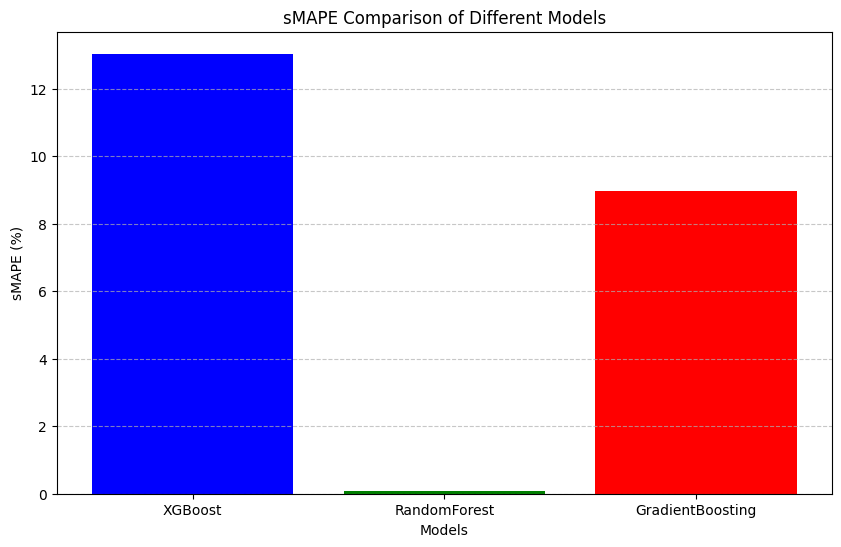

In [5]:
# Extract model names and their corresponding sMAPE values
models = list(performance.keys())
smape_values = [performance[model]['sMAPE'] for model in models]

# Plotting sMAPE of each model
plt.figure(figsize=(10, 6))
plt.bar(models, smape_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('sMAPE (%)')
plt.title('sMAPE Comparison of Different Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
